### setup before running

1. download all 2019 data from "https://webrobots.io/kickstarter-datasets/"
2. make a folder called "raw_data"
3. within "raw_data" make 3 sub-folders with the date of the pulls in the format MM-DD-YYYY
3. extract downloaded data into each of the 3 sub-folders appropriately
4. in line 4 below change the "path_master" variable to your "raw_data" link
5. run (~7min)

### merge all csv

In [ ]:
import re
import os
import pandas as pd
path_master = r'C:/Users/endwy/Documents/Columbia MSBA/Spring 2019/E4650 - Business Analytics/Project - Kickstarter Analysis/raw_data/'
df_kickstarter = pd.DataFrame()

def add_date(path):
    return path[-10:-1]

directories = list()
for root, dirs, files in os.walk(path_master, topdown=False):
    for name in dirs:
        directories.append(os.path.join(root, name)+'/')

file_names = list()
for path, subdirs, files in os.walk(path_master):
    for filename in files:
        if filename not in file_names: file_names.append(filename)

for i in directories: 
    for j in file_names:
        try:
            with open(i+j, encoding='utf8') as fp:
                df_interim = pd.read_csv(fp, keep_default_na=False)
            df_interim['download_date'] = add_date(i)
            df_interim['download_date'] = pd.to_datetime(df_interim['download_date'], format='%m-%d-%Y')
            global df_kickstarter
            df_kickstarter = pd.concat([df_kickstarter,df_interim])
            print('SUCCESS: '+i+j)
        except:
            print('FAIL: '+i+j)
            pass
df_kickstarter.to_csv(path_master+'df_kickstarter'+'.csv')

### read in random sample % of full df_kickstarter to test with

In [ ]:
import pandas as pd
import os
import random
filename = r'C:/Users/endwy/Documents/Columbia MSBA/Spring 2019/E4650 - Business Analytics/Project - Kickstarter Analysis/raw_data/df_kickstarter.csv'

p = 1  # x% of the lines
# keep the header, then take only x% of lines
# if random from [0,1] interval is greater than p the row will be skipped
df = pd.read_csv(filename, header=0,  skiprows=lambda i: i>0 and random.random() > p)
len(df)
#df=df[:1000]
#len(df)

### categorize

In [ ]:
import json
cat_json = df['category'].apply(json.loads)
cat_name=list(map(lambda d: d['name'], cat_json))
df['Cat_Name']=cat_name
#df.sort_values(['Cat_Name'])

### funding date scraping 

In [ ]:
def get_url(x):
    return x.split("\"")[5]

df["urls"] = df["urls"].apply(lambda x: get_url(x))

In [ ]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import datetime

processed = 0
def add_fundpd(x,y):
    user_agent_list = [
           #Chrome
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
            'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
            #Firefox
            'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
            'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)',
            'Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (Windows NT 6.2; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0)',
            'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
            'Mozilla/5.0 (Windows NT 6.1; Win64; x64; Trident/7.0; rv:11.0) like Gecko',
            'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)',
            'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)',
            'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729)'
        ]
    user_agent = random.choice(user_agent_list)
    heads = {'User-Agent': user_agent}
    #sleep(3)
    global proessed
    try:
        page = requests.get(x,headers=heads)
        results_page = BeautifulSoup(page.content,'lxml')
        period = results_page.find('div',class_='NS_campaigns__funding_period').find_all(class_="js-adjust-time")
        global processed
        processed+=1
        print("success: "+str(processed)+" : "+y+" : "+x[36:])
        start = pd.to_datetime(period[0].get_text(), format='%b %d, %Y').strftime('%Y-%m-%d')
        end = pd.to_datetime(period[1].get_text(), format='%b %d, %Y').strftime('%Y-%m-%d')
        delta = int(results_page.find('p',class_='f5').get_text().split("\n")[-2][1:-1].split()[0])
        if y=="start": result = start
        if y=="end": result = end
        if y=="delta": result = delta
        return result
    except:
        processed+=1
        print("FAIL: "+str(processed)+" : "+y+" : "+x[36:])
        result = "error"
        return result
df["funding_start"] = df["urls"].apply(lambda x: add_fundpd(x,'start'))
df["funding_end"] = df["urls"].apply(lambda x: add_fundpd(x,'end'))
df["funding_delta"] = df["urls"].apply(lambda x: add_fundpd(x,'delta'))

In [19]:
df.head(3)

,Unnamed: 0,Unnamed: 0.1,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,...,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,download_date,funding_start,funding_end,funding_delta
0,0,277,96,Choose My Music Records is a UK indie label. ...,"{""id"":40,""name"":""Indie Rock"",""slug"":""music/ind...",4266,GB,1351932368,"{""id"":351383297,""name"":""Dominik Paczko"",""is_re...",GBP,...,successful,1362553810,1.579993,https://www.kickstarter.com/projects/351383297...,4450.841661,international,2019-01-17,2013-02-12,2013-03-06,22
1,1,360,3,Original urban lifestyle sneaker designed with...,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",270,US,1499178152,"{""id"":483350489,""name"":""Sir Benni Miles"",""is_r...",USD,...,failed,1502212923,1.000000,https://www.kickstarter.com/projects/483350489...,270.000000,domestic,2019-01-17,2017-07-05,2017-08-08,33
2,2,457,8,The Acquisition Tank is an original science-fi...,"{""id"":24,""name"":""Performance Art"",""slug"":""art/...",918,CA,1404746351,"{""id"":1172834748,""name"":""Adam Charbonneau"",""sl...",CAD,...,successful,1410152340,0.938523,https://www.kickstarter.com/projects/the-acqui...,938.522990,domestic,2019-01-17,2014-07-11,2014-09-08,58


### NLP / WordClouds

In [ ]:
def extract_creator_id(json_obj):
    try:
        temp=json.loads(json_obj)
    except:
        return None
    return temp['id']
    
creator_id = kickstarter_df['creator'].apply(extract_creator_id)

In [ ]:
def extract_reward_urls(json_obj):
    temp = json.loads(json_obj)
    return (temp['web']['rewards'])
    
reward_urls=kickstarter_df['urls'].apply(extract_reward_urls)

In [ ]:
def pull_reward_details(url_list):
    
    reward_tier = list()
    #Read the urls and extract details on rewarding tiers
    for i in url_list:
        #print(i)
        response=requests.get(i)
        if response.status_code!=200:
            print("Error pulling data from {}".format(i))
            continue
        reward_desc=bs(response.content,'lxml')
        a=reward_desc.find('ol').find_all('li')
        reward_tier.append(len(a))
    
    return (reward_tier)
        
reward_tier = pull_reward_details(reward_urls)

In [ ]:
a = pd.DataFrame({"Project_Id":kickstarter_df['id'],
                  "Creator_Id":creator_id,
                  "Reward_Tiers":reward_tier,
                  "Rewards_Url":reward_urls})
a

In [ ]:
#Adding the Word Cloud Segment, this needs to be applied on overfunded campaigns to better
#suggest what works best in this area

In [65]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize,word_tokenize

#def generate wordclouds(df):
#df = pd.read_csv("df_testing.csv")  

MIN_LENGTH=5
DELETE_WORDS=['first','world','creat','music']

def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string


def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string

In [66]:
def aggregate_text(temp):
    p_stemmer = PorterStemmer()
    x=''
    for i in range(len(temp)):
        words = word_tokenize(temp['blurb'].iloc[i])
        text = ([p_stemmer.stem(i).lower() for i in words])
        text = ' '.join(text)
        x=x+' '+text
        
    return x.lower()

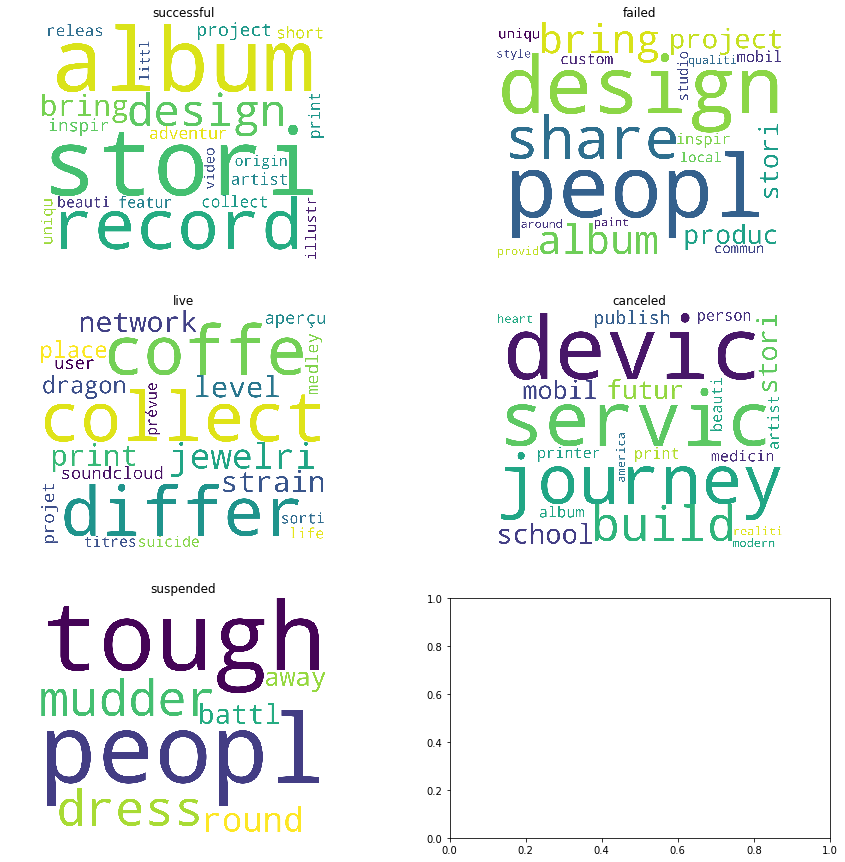

In [67]:
category_list = list()
category_description=list()

COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))


def category_state_geography(df):
    count = 0
    df = df.dropna(how='any',axis=0)
    for i in df['state'].unique():
        temp = df[df['state']==i]
        temp_blurbs = aggregate_text(temp)
        temp_blurbs = remove_words(temp_blurbs)
        temp_blurbs = remove_short_words(temp_blurbs)
        category_list.append(i)
        category_description.append(temp_blurbs)
        ax = axes[count//2, count%2] 
        ax.set_title(i)
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(temp_blurbs)
        ax.imshow(wordcloud)
        ax.axis('off')
        count+=1
    
category_state_geography(df[['blurb','state']])
plt.show()

In [40]:
#df['state'].unique()
#df_new=df[df['state']=='successful']


### overfunding